<a href="https://colab.research.google.com/github/soulayman-al-abdallah/Data-Science-Projects/blob/main/M07_Machine_Translation_Seq2Seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Using Seq2seq for machine translation purposes

---
We will be working on machine translation problem,

**input**: english sentence

**output**: french sentence

Trying to imittate the way google translate works ✍

## Importing Libraries

In [2]:
import pandas as pd
import numpy as np

## Getting the data

In [3]:
!git clone https://github.com/zaka-ai/machine_learning_certification

Cloning into 'machine_learning_certification'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 43 (delta 10), reused 10 (delta 1), pack-reused 0
Unpacking objects: 100% (43/43), done.


In [4]:
%cd /content/machine_learning_certification/Challenge 7

/content/machine_learning_certification/Challenge 7


We read the english sentences in a dataframe named "english", and the french sentences in a dataframe named "french"

In [5]:
#creating a dataframe for the english sentences
english = pd.read_csv('en.csv', header = None)
english.head()

,0
0,"new jersey is sometimes quiet during autumn , ..."
1,the united states is usually chilly during jul...
2,"california is usually quiet during march , and..."
3,the united states is sometimes mild during jun...
4,"your least liked fruit is the grape , but my l..."


In [6]:
#creating a dataframe for the french sentences
french = pd.read_csv('fr.csv', header = None)
french.head()

,0
0,new jersey est parfois calme pendant l' automn...
1,les états-unis est généralement froid en juill...
2,"california est généralement calme en mars , et..."
3,"les états-unis est parfois légère en juin , et..."
4,"votre moins aimé fruit est le raisin , mais mo..."




---



In [7]:
#checking number of samples
print("We have {} english sentences and {} french sentences".format(len(english), len(french)))

We have 137860 english sentences and 137860 french sentences




---



In [8]:
#two dataframes in one
df = pd.concat([english, french], axis=1)
df.head()

,0,0
0,"new jersey is sometimes quiet during autumn , ...",new jersey est parfois calme pendant l' automn...
1,the united states is usually chilly during jul...,les états-unis est généralement froid en juill...
2,"california is usually quiet during march , and...","california est généralement calme en mars , et..."
3,the united states is sometimes mild during jun...,"les états-unis est parfois légère en juin , et..."
4,"your least liked fruit is the grape , but my l...","votre moins aimé fruit est le raisin , mais mo..."




---



Let's name the columns as **English** and **French** so that we access them easier.

In [9]:
#providing column names for each column
df.columns = ['English', 'French']
df.head()

,English,French
0,"new jersey is sometimes quiet during autumn , ...",new jersey est parfois calme pendant l' automn...
1,the united states is usually chilly during jul...,les états-unis est généralement froid en juill...
2,"california is usually quiet during march , and...","california est généralement calme en mars , et..."
3,the united states is sometimes mild during jun...,"les états-unis est parfois légère en juin , et..."
4,"your least liked fruit is the grape , but my l...","votre moins aimé fruit est le raisin , mais mo..."




---



In [10]:
#trying one sample in both languages
print("English:", df['English'][2])
print("French:", df['French'][2])

English: california is usually quiet during march , and it is usually hot in june .
French: california est généralement calme en mars , et il est généralement chaud en juin .




---



##Cleaning Data

### Remove punctutations

In [11]:
import regex as re

def remove_punctuation(text):
  return re.sub(r'[.!?:;,]', '', text)

In [12]:
df['English'] = df['English'].apply(lambda x: remove_punctuation(x))
df['French'] = df['French'].apply(lambda x: remove_punctuation(x))

In [13]:
#checking the same sentences after removing punctuations
print("French:", df['French'][2])
print("English:", df['English'][2])

French: california est généralement calme en mars  et il est généralement chaud en juin 
English: california is usually quiet during march  and it is usually hot in june 




---



##Exploring the Data

### Sentences length

In [14]:
#adding a column that counts the number of english words in each sentence
df["ENG Length"] = df["English"].apply(lambda x: len(x.split()))
df.head()

,English,French,ENG Length
0,new jersey is sometimes quiet during autumn a...,new jersey est parfois calme pendant l' automn...,13
1,the united states is usually chilly during jul...,les états-unis est généralement froid en juill...,15
2,california is usually quiet during march and ...,california est généralement calme en mars et ...,13
3,the united states is sometimes mild during jun...,les états-unis est parfois légère en juin et ...,14
4,your least liked fruit is the grape but my le...,votre moins aimé fruit est le raisin mais mon...,14


In [15]:
#adding a column that counts the number of french words in each sentence
df["FR Length"] = df["French"].apply(lambda x: len(x.split()))
df.head()

,English,French,ENG Length,FR Length
0,new jersey is sometimes quiet during autumn a...,new jersey est parfois calme pendant l' automn...,13,14
1,the united states is usually chilly during jul...,les états-unis est généralement froid en juill...,15,13
2,california is usually quiet during march and ...,california est généralement calme en mars et ...,13,13
3,the united states is sometimes mild during jun...,les états-unis est parfois légère en juin et ...,14,13
4,your least liked fruit is the grape but my le...,votre moins aimé fruit est le raisin mais mon...,14,14




---



Visualize the distribution of the lengths of english sentences and french sentences.

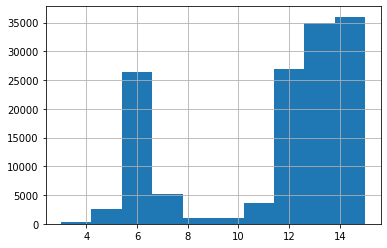

In [16]:
df["ENG Length"].hist()

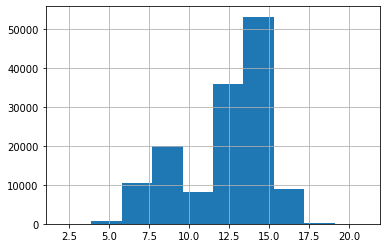

In [17]:
df["FR Length"].hist()

The maximum length of an english sentence and the maximum length of a french sentence, are useful later in the modeling phase.

In [18]:
max_eng = max(df["ENG Length"])
max_fr = max(df["FR Length"])

print("The longest english sentence is made of {} words and the longest french sentence is made of {} words".format(max_eng, max_fr))

The longest english sentence is made of 15 words and the longest french sentence is made of 21 words


##Preprocessing the Data

In order for the data to be fed to the model, it has to be **tokenized** and **padded**. 
We will create a unique tokenizer for each language, since it's dealing with a specific dictionary of a specific language.

### Tokenizing

In [19]:
from keras.preprocessing.text import Tokenizer

fr_tokenizer = Tokenizer()
fr_tokenizer.fit_on_texts(df['French'])

eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(df['English'])

In [20]:
fr_tokenized = fr_tokenizer.texts_to_sequences(df['French'])
eng_tokenized = eng_tokenizer.texts_to_sequences(df['English'])

In [ ]:
eng_tokenized

#                   ----RETURNS----
# [[17, 23, 1, 8, 67, 4, 39, 7, 3, 1, 55, 2, 44],
#  [22, 1, 9, 67, 4, 38, 7, 3, 1, 9, 68, 2, 34],
#  [5, 20, 21, 1, 8, 64, 4, 34, 7, 3, 1, 57, 2, 42].....]

fr_tokenized
#                   ----RETURNS----
# [[35, 34, 1, 8, 67, 37, 11, 24, 6, 3, 1, 112, 2, 50],
#  [4, 32, 31, 1, 12, 19, 2, 49, 6, 3, 95, 69, 2, 51],
#  [101, 1, 12, 67, 2, 45, 6, 3, 1, 12, 21, 2, 41],.....]



---



In [22]:
#Getting the vocab size = unique words in all sentences used of same language

eng_vocab_size = len(eng_tokenizer.word_index)
fr_vocab_size = len(fr_tokenizer.word_index)

print("We have {} english words and {} french words".format(eng_vocab_size, fr_vocab_size))

We have 199 english words and 344 french words




---



### Padding

Performing padding on the sequences to fix their length based on the maximum length in each language, 15 for english and 21 for french ones.

In [23]:
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences

fr_tokenized_padded = pad_sequences(fr_tokenized, maxlen = max_fr, padding='post')
eng_tokenized_padded = pad_sequences(eng_tokenized, maxlen = max_eng, padding='post')

In [24]:
eng_tokenized_padded

#                   ----RETURNS----
#       [[17, 23,  1, ..., 44,  0, 0],
#       [ 5, 20, 21, ..., 51,  2, 45],
#       [22,  1,  9, ..., 34,  0,  0],....]

fr_tokenized_padded
#                   ----RETURNS----
# [[ 35,  34,   1, ...,   0,   0,   0],
# [  4,  32,  31, ...,   0,   0,   0],
# [101,   1,  12, ...,   0,   0,   0],....]

array([[ 35,  34,   1, ...,   0,   0,   0],
       [  4,  32,  31, ...,   0,   0,   0],
       [101,   1,  12, ...,   0,   0,   0],
       ...,
       [ 11,  30,   1, ...,   0,   0,   0],
       [  7,  33,   1, ...,   0,   0,   0],
       [ 84,   1,  20, ...,   0,   0,   0]], dtype=int32)



---



##Modeling

After preprrocessing the data, we can build our model. We can rely on RNNs, LSTMs, or GRUs...etc to build Seq2Seq models.

In [25]:
from keras.layers import Dense, LSTM, GRU, Embedding, RepeatVector, Input, TimeDistributed, Bidirectional
from keras.models import Sequential

model = Sequential()

model.add(Embedding(input_dim=(eng_vocab_size+1), output_dim=100 , input_length=max_eng))   #max_fr = 15 = max length of english sentences    output_dim: dimension of the dense embedding.
model.add(GRU(20))
model.add(RepeatVector(max_fr))   #max_fr = 21 = max length of french sentences
model.add(GRU(20, return_sequences=True))
model.add(TimeDistributed(Dense(units=(fr_vocab_size+1), activation="softmax")))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 100)           20000     
                                                                 
 gru (GRU)                   (None, 20)                7320      
                                                                 
 repeat_vector (RepeatVector  (None, 21, 20)           0         
 )                                                               
                                                                 
 gru_1 (GRU)                 (None, 21, 20)            2520      
                                                                 
 time_distributed (TimeDistr  (None, 21, 345)          7245      
 ibuted)                                                         
                                                                 
Total params: 37,085
Trainable params: 37,085
Non-traina

Compile and train the model.

In [26]:
#We use sparse categorical crossentropy because we did not one hot encode our output
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x = eng_tokenized_padded, y=fr_tokenized_padded, validation_split=0.2, epochs = 25, batch_size=64)

Epoch 1/25
1724/1724 [==============================] - 85s 47ms/step - loss: 2.6619 - accuracy: 0.4687 - val_loss: 2.1999 - val_accuracy: 0.5163
Epoch 2/25
1724/1724 [==============================] - 75s 43ms/step - loss: 1.9707 - accuracy: 0.5305 - val_loss: 1.7581 - val_accuracy: 0.5579
Epoch 3/25
1724/1724 [==============================] - 77s 44ms/step - loss: 1.6192 - accuracy: 0.5827 - val_loss: 1.5044 - val_accuracy: 0.6011
Epoch 4/25
1724/1724 [==============================] - 77s 45ms/step - loss: 1.4261 - accuracy: 0.6146 - val_loss: 1.3441 - val_accuracy: 0.6351
Epoch 5/25
1724/1724 [==============================] - 76s 44ms/step - loss: 1.2752 - accuracy: 0.6494 - val_loss: 1.2166 - val_accuracy: 0.6612
Epoch 6/25
1724/1724 [==============================] - 74s 43ms/step - loss: 1.1723 - accuracy: 0.6716 - val_loss: 1.1280 - val_accuracy: 0.6808
Epoch 7/25
1724/1724 [==============================] - 76s 44ms/step - loss: 1.1008 - accuracy: 0.6866 - val_loss: 1.0662 -

Note: We can do one hot encoding and use categorical cross entropy instead



---



Defining a function that gets an input sentence in english and gives the output sentence in the french language.

In [29]:
def final_predictions_model1(sentence):
    
    y_id_to_word = {value: key for key, value in fr_tokenizer.word_index.items()}   #preparing the words of vocab with their indices in a dictionary
    #print(y_id_to_word)     gives {1: 'est', 2: 'en', 3: 'il'....}
    y_id_to_word[0] = '<PAD>'                                                       #adding a zero key with <pad> value to the dictionary
    #print(y_id_to_word)     gives {1: 'est', 2: 'en', 3: 'il'..., 0: '<PAD>'}

    sentence = eng_tokenizer.texts_to_sequences([sentence])                         #transforming the argument sentence to a sequence of integers based on the tokenizer
    #print(sentence)         gives [[27, 1, 107, 5, 101]] in example
    
    sentence = pad_sequences(sentence, maxlen=max_eng, padding='post')
    predictions = model.predict(sentence)

    print(' '.join([y_id_to_word[np.argmax(x)] for x in predictions[0]]))

Test the following sentence

In [32]:
input = "she is driving the truck "

final_predictions_model1(input)

nous son le <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


Accurate translation right? 😄
Surely not, it depends on a lot of parameters, we definitely need a stronger bigger vocab to teach to the model.



---



**Saving the model and the tokenizers in portable files**

In [ ]:
model.save("tran_model.h5")

In [42]:
import pickle

# saving
with open('en_tokenizer.pickle', 'wb') as MyEngTokenizer:
    pickle.dump(eng_tokenizer, MyEngTokenizer, protocol=pickle.HIGHEST_PROTOCOL)

In [43]:

# saving
with open('fr_tokenizer.pickle', 'wb') as MyFrTokenizer:
    pickle.dump(fr_tokenizer, MyFrTokenizer, protocol=pickle.HIGHEST_PROTOCOL)